In [1]:
from data import *
from model import DiffusionMap
from plot import *
from train import train_vae, train_resnet18
import torch
import torchvision
import time
from matplotlib import pylab
from sklearn.model_selection import train_test_split
import datafold.pcfold as pfold
from datafold.dynfold import DiffusionMaps


%load_ext autoreload
%autoreload 2

## Swiss Roll

d:\study-TUM\23ss\praktikum\Final project\final_proj\src\plot.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


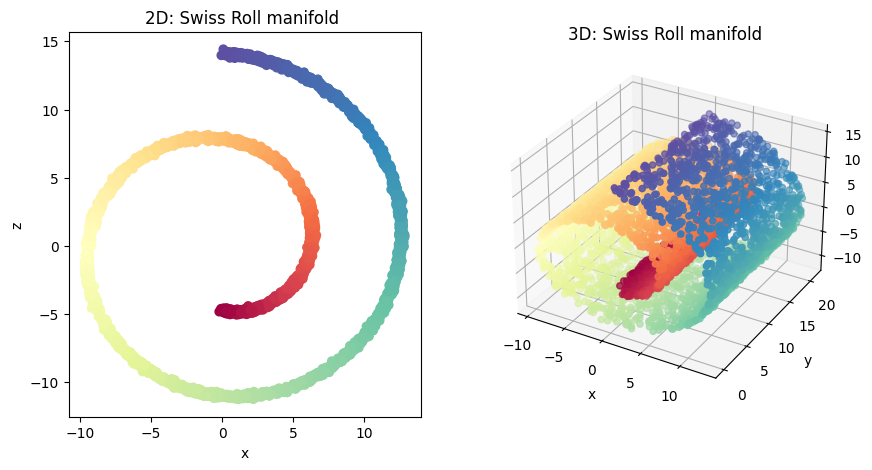

In [2]:
#n=50000 crashed
#n=40000 crashed
#n=30000 crashed
#n=20000 crashed
nr_samples=5000
data, timesteps = get_swiss_roll(nr_samples)
plot_swiss_roll(nr_samples,data, timesteps)

In [3]:
L=10
dmap = DiffusionMap()


In [4]:
start = time.time()
phi_l, lambda_l  = dmap.diffusion_map(data,L)
end = time.time()

print(f"The run time is : {end - start}")


The run time is : 457.0881013870239


Print 10 largest eigenvalues for the corresponding dataset: 
 [1.         0.99986397 0.99944195 0.99876269 0.99779853 0.99764499
 0.99744921 0.99703876 0.99657016 0.99636566 0.99546808]


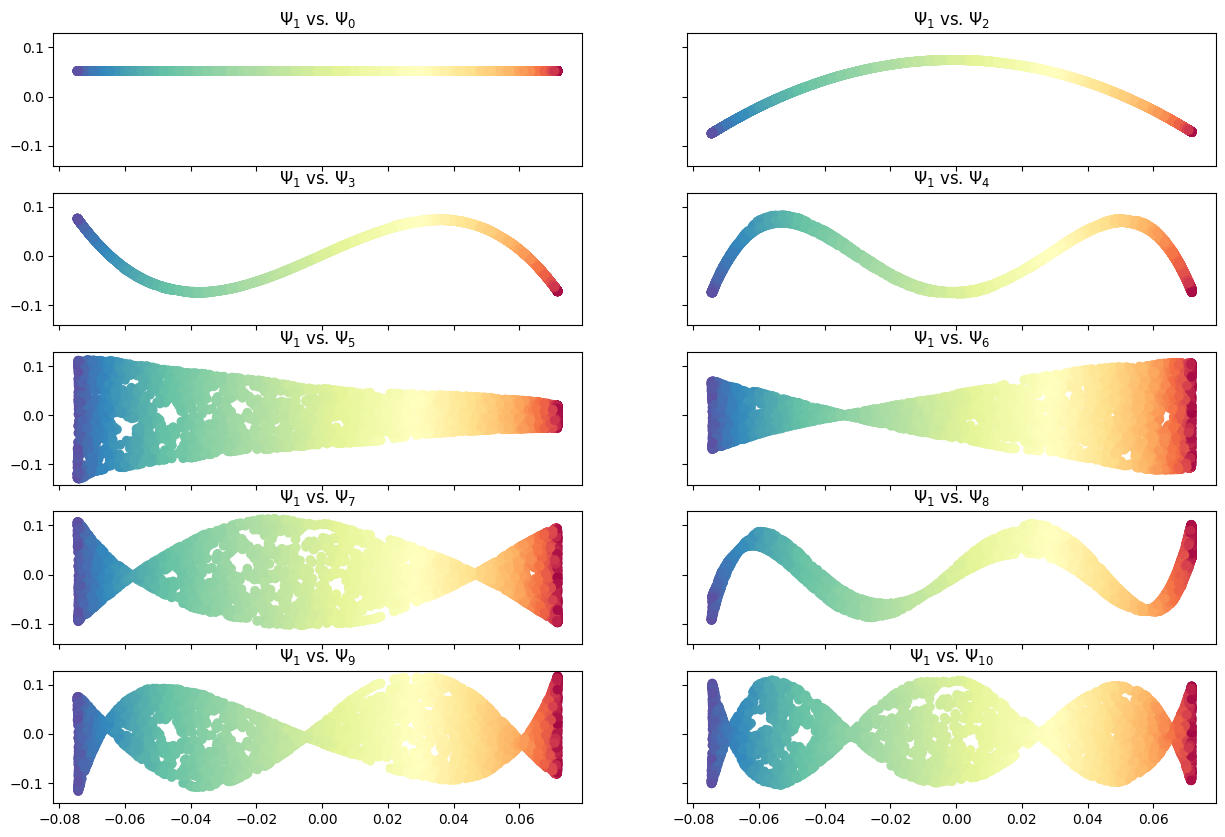

<Figure size 1000x450 with 0 Axes>

In [5]:
# Plot the eigenfunctions with respect to time
plot_diffusion_maps(nr_samples, L, phi_l,lambda_l ,timesteps)

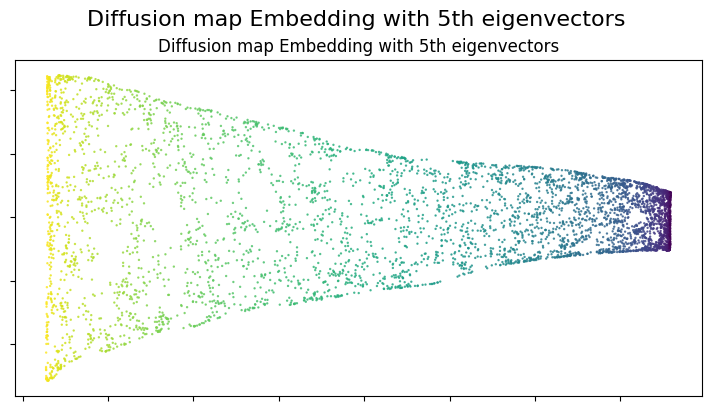

In [6]:
phi_l_plot = np.concatenate((phi_l[:, 1].reshape(-1, 1), phi_l[:, 5].reshape(-1, 1)), axis=1)
plot_2d(phi_l_plot, timesteps, "Diffusion map Embedding with 5th eigenvectors")

In [7]:
start = time.time()
evecs, evals = dmap.diffusion_map_datafold(data,L)
end = time.time()

print(f"The run time is : {end - start}")

The run time is : 4.994703531265259


Print 10 largest eigenvalues for the corresponding dataset: 
 [1.         0.99971458 0.99881555 0.9973872  0.99535863 0.99501357
 0.99449101 0.99369103 0.99276788 0.99224688]


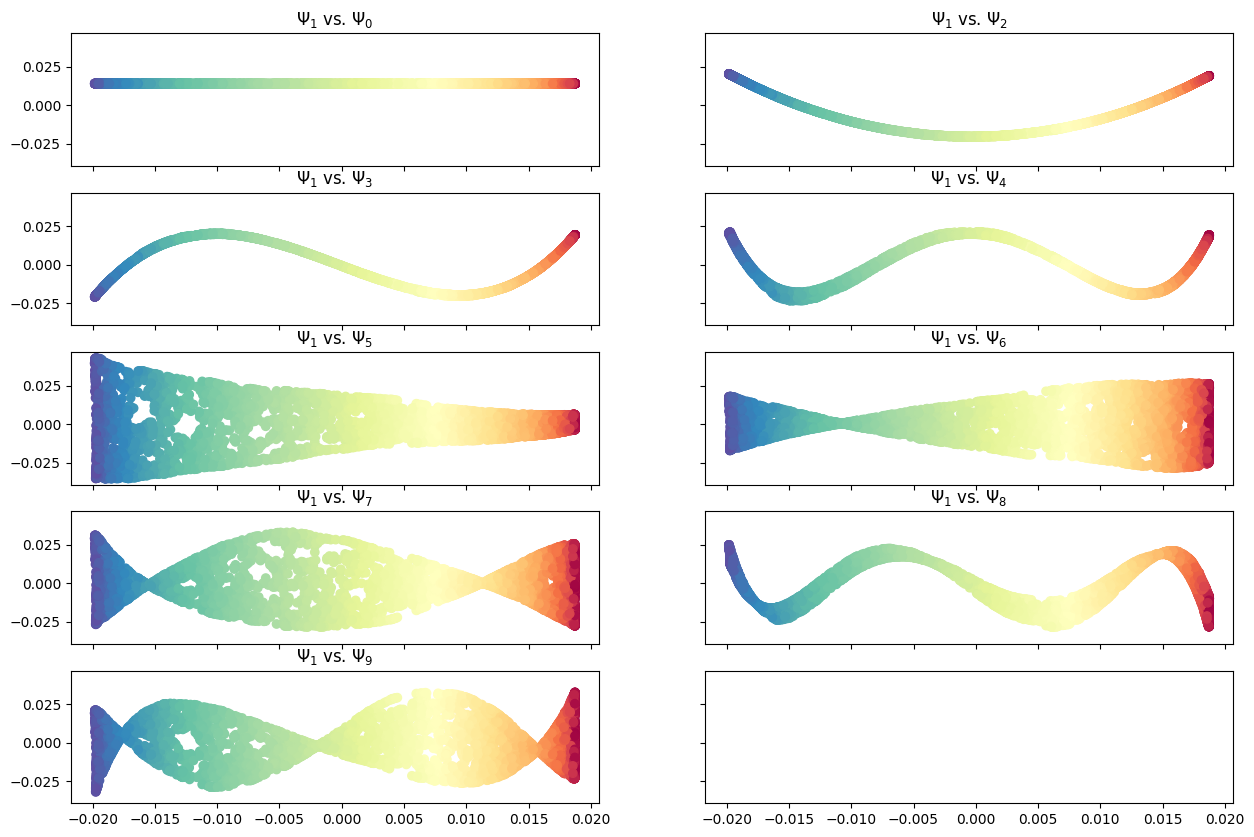

<Figure size 1000x450 with 0 Axes>

In [8]:
plot_diffusion_maps(nr_samples, L, evecs, evals ,timesteps)

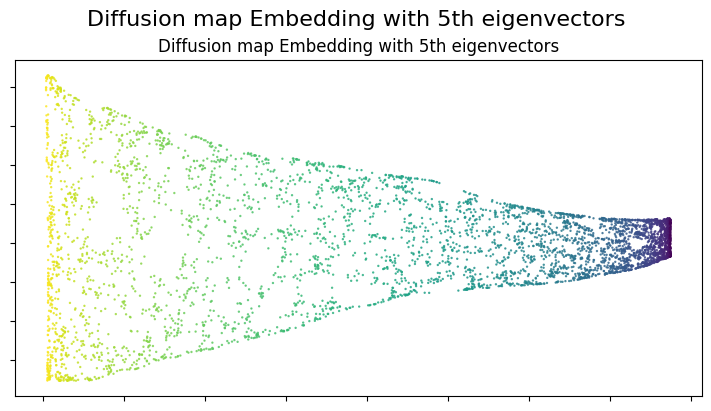

In [10]:
phi_l_plot = np.concatenate((evecs[:, 1].reshape(-1, 1), evecs[:, 5].reshape(-1, 1)), axis=1)
plot_2d(phi_l_plot, timesteps, "Diffusion map Embedding with 5th eigenvectors")

## Word2vec

In [9]:
gensim_model  = gensim.downloader.load("word2vec-google-news-300")

In [11]:
#10000 crashed
num_data_sample=5000

index = np.random.randint(0, len(gensim_model.index_to_key), (num_data_sample))
words = [gensim_model.index_to_key[i] for i in index]
embeddings = [gensim_model[word] for word in words]

In [12]:
data_word=np.array(embeddings)
X = data_word

In [7]:
def diffsuion_map_wordembedding(data):
    X_pcm = pfold.PCManifold(X)
    X_pcm.optimize_parameters(result_scaling=2)

    print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

    t0 = time.time()
    dmap = DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
    n_eigenpairs=6,
    dist_kwargs=dict(cut_off=X_pcm.cut_off),
    )
    dmap = dmap.fit(X_pcm)
    dmap = dmap.set_target_coords([1, 2])
    X_dmap = dmap.transform(X_pcm)

    return X_dmap


In [15]:
start = time.time()
X_dmap=diffsuion_map_wordembedding(X)
end = time.time()
print(f"The run time is : {end - start}")

epsilon=10.834098967143468, cut-off=14.12697696685791
The run time is : 422.53971672058105


In [18]:
def plot_embedding(X_dmap, words):
  pylab.figure(figsize=(16, 9))
  for i, label in enumerate(words[:400]):
    x, y = X_dmap[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom')
  pylab.show()

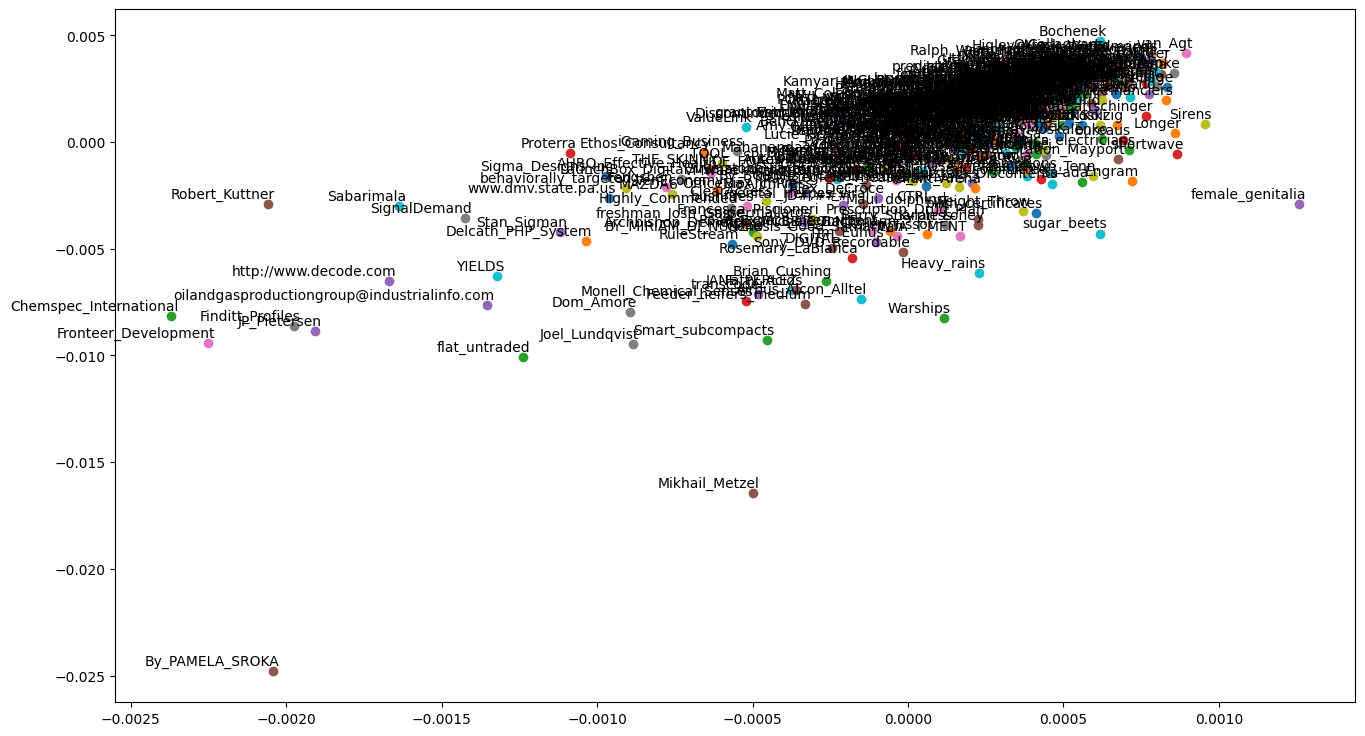

In [19]:
plot_embedding(
    X_dmap,words
)

In [ ]:
%matplotlib

In [ ]:
%matplotlib

plot_embedding(
    X_dmap,words
)

## Cifar 10

In [2]:
train_loader, val_loader, test_loader = cifar10(train_val_split = [45000, 5000], batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([32, 3, 32, 32])


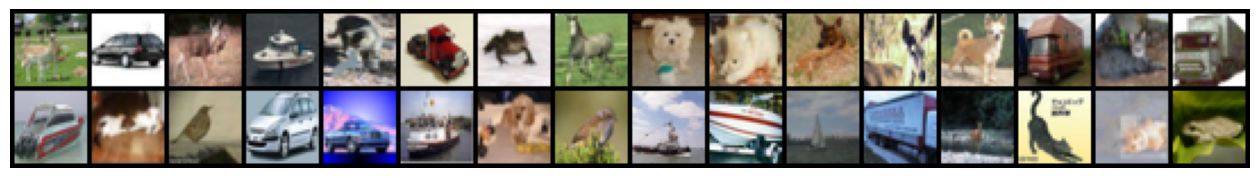

In [3]:
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [14]:
train_labels = np.array([])
train_images = np.empty((0, 3072), dtype=np.float32)

# Set the number of random examples to select
num_examples = 5000

# Randomly select a subset of examples
indices = np.random.choice(len(train_loader.dataset), size=num_examples, replace=False)

for idx, (images, labels) in enumerate(train_loader):
    if idx in indices:
        # Reshape images to (batch_size, 3072)
        images = images.view(images.size(0), -1)
        
        # Append the labels and images to the respective arrays
        train_labels = np.append(train_labels, labels.numpy())
        train_images = np.concatenate((train_images, images.numpy()), axis=0)
    
    if len(train_labels) >= num_examples:
        break

# Print the shapes of the arrays
print("Train labels shape:", train_labels.shape)
print("Train images shape:", train_images.shape)


Train labels shape: (5024,)
Train images shape: (5024, 3072)


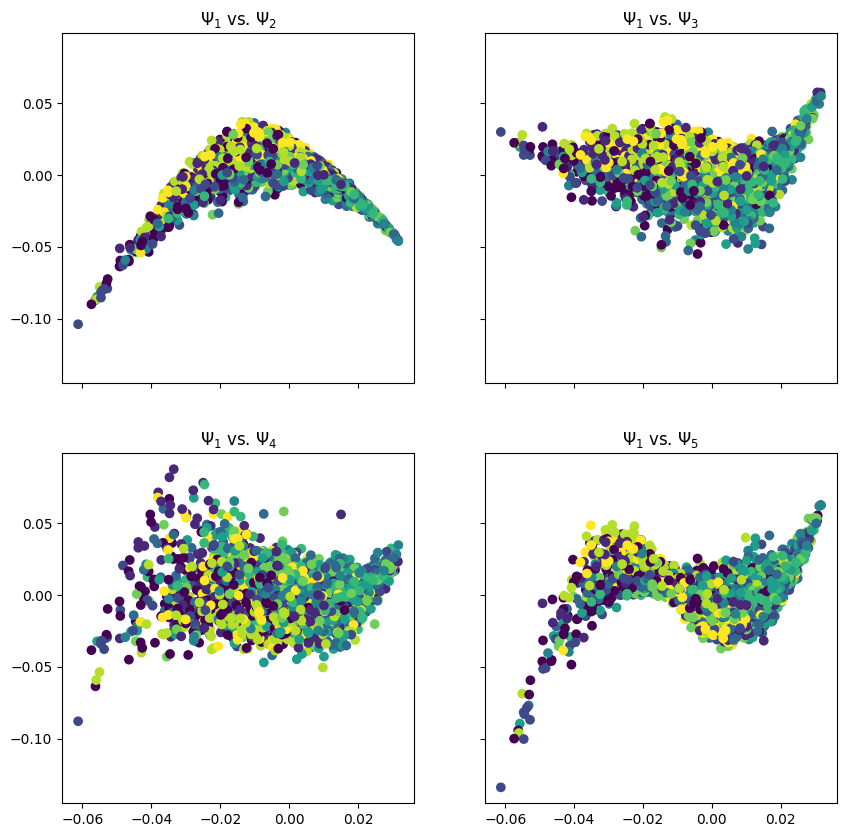

In [28]:
dmap = DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=c_pcm.kernel.epsilon),
    n_eigenpairs=6,
    dist_kwargs=dict(cut_off=c_pcm.cut_off),
)
dmap = dmap.fit(c_pcm)
plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_[:, 1:],
    n=0,
    idx_start=1,
    fig_params=dict(figsize=(10, 10)),
    scatter_params=dict(c=train_labels),
)

In [30]:
# Source code taken and adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html


def plot_embedding(X, y, digits, title=None):
    """Scale and visualize the embedding vectors"""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=[10, 10])
    ax = plt.subplot(111)

    for i in range(X.shape[0]):
        plt.text(
            X[i, 0],
            X[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1.0, 1.0]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits[i], cmap=plt.cm.gray_r), X[i]
            )
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])

    if title is not None:
        plt.title(title)